# Twitter Sentiment Analysis - POC
---

## 4. Cleanup Pipeline - version 2

Repurposing the original count vectorizer to become a Tfidf vectorizer, ended up with a hybric approach, pipeline with part custom (count vectorizer) and part sklearn (tfidf). 

This is the notebook that implements it.

In [27]:
import os
import time
import json
import numpy as np
import pandas as pd
import scipy.sparse as sp

# custom
import cleanup_module_POC as Cmod

from scipy.sparse import csr_matrix
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfTransformer

### load minimally prepared X, y train subsets; split for POC

In [21]:
raw_path = os.path.join("..","data","1_raw","sentiment140")
X_train = pd.read_csv(os.path.join(raw_path, "X_train.csv"))
y_train = pd.read_csv(os.path.join(raw_path, "y_train.csv"))

In [22]:
X, X_rest, y, y_rest = train_test_split(X_train, y_train, test_size=0.79, random_state=42)

In [23]:
print(f'Dataset size: {len(X):0.0f}')
print(f'Target distribution: {sum(y["target"])/len(y):0.3f}')

Dataset size: 251468
Target distribution: 0.500


In [28]:
# transform into arrays (X_array of strings)
X_array = np.array(X.iloc[:, 2]).ravel()
y_array = y.iloc[:,0].ravel()

### Pre-process subset with 1,000 features

Since pre-processing with a larger feature space takes time, I'll establish a naming convention for saving pre-processed data which includes the following scheme: 
- X train or test
- transformed (for clarification)
- representation (BoW, Tfidf, etc.)
- m: in 1000s (k)
- n: in 1000s (k)


In [60]:
try:
    # load X_train_transformed 
    X_train_transformed = sp.load_npz(os.path.join(proc_dir, "X_train_transformed_Tfidf_250k_1k.npz"))
    print('Loading X_train_transformed...')
except FileNotFoundError as e:
    print('Preprocessing X_array as Tfidf with m=250k, n=1k...')
    preprocess_pipeline = Pipeline([
            ("document_to_wordcount", Cmod.DocumentToWordCounterTransformer()),
            ("wordcount_to_bow", Cmod.WordCounterToVectorTransformer(vocabulary_size=1000)), # default
            ("bow_to_tfidf", TfidfTransformer())
    ])
    start_pipeline = time.time()
    
    # pre-process...
    #X_train_transformed = preprocess_pipeline.fit_transform(X_array) # avoid, need vocab and IDFs
    X_wordcounter = preprocess_pipeline['document_to_wordcount'].fit_transform(X_array)
    X_wordcounter_fit = preprocess_pipeline['wordcount_to_bow'].fit(X_wordcounter) # gets vocab
    X_bow = X_wordcounter_fit.transform(X_wordcounter)
    X_bow_fit = preprocess_pipeline['bow_to_tfidf'].fit(X_bow) #.idf_ # get IDFs
    X_train_transformed = preprocess_pipeline['bow_to_tfidf'].fit_transform(X_bow)

    # save preprocessed data
    proc_dir = os.path.join("..","data","3_processed","sentiment140")
    # vocab
    with open(os.path.join(proc_dir, 'X_train_transformed_Tfidf_250k_1k_vocab.json'), 'w') as outfile:
        json.dump(X_wordcounter_fit.vocabulary_, outfile) 
    # idfs
    with open(os.path.join(proc_dir, "X_train_transformed_TrainIDFs_1k.npy"), 'wb') as f:
        np.save(f, X_bow_fit.idf_)
    # X_transformed
    sp.save_npz(os.path.join(proc_dir, 'X_train_transformed_Tfidf_250k_1k.npz'), X_train_transformed)  

    # print processing time
    mins, secs = divmod(time.time() - start_pipeline, 60)
    print(f'Preprocessing time: {mins:0.0f} minute(s) and {secs:0.0f} second(s).')

Loading X_train_transformed...


In [61]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB

NB_clf = MultinomialNB()
score = cross_val_score(NB_clf, X_train_transformed, y_array, cv=10, verbose=1, scoring='accuracy')
print('Mean accuracy: ' + str(round(score.mean(),4)))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Mean accuracy: 0.7539


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.6s finished


In [62]:
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression(solver="liblinear", random_state=42)
score = cross_val_score(log_clf, X_train_transformed, y_array, cv=10, verbose=1, scoring='accuracy')
print('Mean accuracy: ' + str(round(score.mean(),4)))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Mean accuracy: 0.7684


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   12.3s finished


In [57]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

def plot_learning_curves_feed_m(model, X, y, Xname):
    """Plot the learning curves for train and validation sets
       , by adding more rows (m) and keeping the number of 
       features (n) constant.
       Args:
           model: a classifier
           X: sparce matrix of features
           y: target vector
           Xname: vectorization method
       Evaluates accuracy (TODO: implement other metrics)
    """
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                          test_size=0.2, 
                                                          random_state=42)
    # train
    # change data granularity (denominator) for more data points
    data_granularity = int(X_train.shape[0]/10)
    
    xs, train_acc, valid_acc = [], [], []

    for m in range(10, X_train.shape[0], data_granularity):       
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_valid_predict = model.predict(X_valid)
        train_acc.append(accuracy_score(y_train[:m], y_train_predict))
        valid_acc.append(accuracy_score(y_valid, y_valid_predict))
        xs.append(str(m-1))

    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_axes([0.0, 
                       # dynamically calculate number of x ticks
                       round(X_train.shape[0]/data_granularity, 0), 
                       0.4, 0.8])
    plt.plot(xs, np.sqrt(train_acc), 'r--', linewidth=.8, 
             label="train accuracy")
    plt.plot(xs, np.sqrt(valid_acc), 'b--', linewidth=.8, 
             label="validation accuracy")
    plt.xticks(rotation=45)
    plt.title(''.join(["Learning Rates for Training and Validation - ", 
                       Xname]), 
              fontsize=16)
    plt.legend(loc="lower right", fontsize=14)
    plt.xlabel("Training Set Size", fontsize=14)
    plt.ylabel("Accuracy", fontsize=14)
    plt.show()

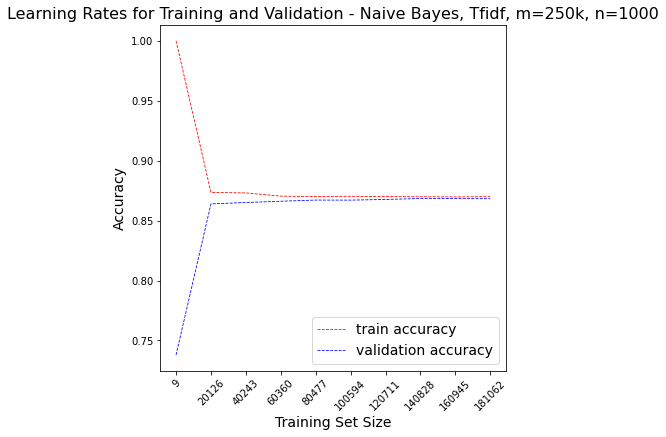

In [58]:
plot_learning_curves_feed_m(NB_clf, X_train_transformed, y_array, 
                           'Naive Bayes, Tfidf, m=250k, n=1000')

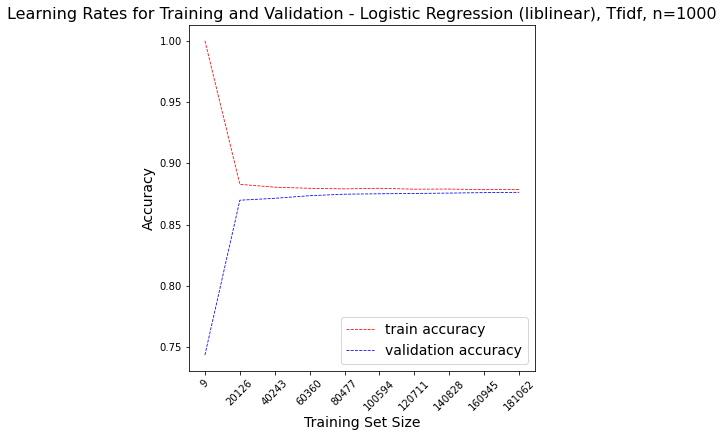

In [59]:
plot_learning_curves_feed_m(log_clf, X_train_transformed, y_array, 
                            'Logistic Regression (liblinear), Tfidf, n=1000')

### Pre-process subset with 50,000 features

In [63]:
try:
    # load X_train_transformed 
    X_train_transformed = sp.load_npz(os.path.join(proc_dir, "X_train_transformed_Tfidf_250k_50k.npz"))
    print('Loading X_train_transformed...')
except FileNotFoundError as e:
    print('Preprocessing X_array as Tfidf with m=250k, n=50k...')
    preprocess_pipeline = Pipeline([
            ("document_to_wordcount", Cmod.DocumentToWordCounterTransformer()),
            ("wordcount_to_bow", Cmod.WordCounterToVectorTransformer(vocabulary_size=50000)), # n=50k
            ("bow_to_tfidf", TfidfTransformer())
    ])
    start_pipeline = time.time()
    
    # pre-process...
    #X_train_transformed = preprocess_pipeline.fit_transform(X_array) # avoid, need vocab and IDFs
    X_wordcounter = preprocess_pipeline['document_to_wordcount'].fit_transform(X_array)
    X_wordcounter_fit = preprocess_pipeline['wordcount_to_bow'].fit(X_wordcounter) # gets vocab
    X_bow = X_wordcounter_fit.transform(X_wordcounter)
    X_bow_fit = preprocess_pipeline['bow_to_tfidf'].fit(X_bow) #.idf_ # get IDFs
    X_train_transformed = preprocess_pipeline['bow_to_tfidf'].fit_transform(X_bow)

    # save preprocessed data
    proc_dir = os.path.join("..","data","3_processed","sentiment140")
    # vocab
    with open(os.path.join(proc_dir, 'X_train_transformed_Tfidf_250k_50k_vocab.json'), 'w') as outfile:
        json.dump(X_wordcounter_fit.vocabulary_, outfile) 
    # idfs
    with open(os.path.join(proc_dir, "X_train_transformed_TrainIDFs_50k.npy"), 'wb') as f:
        np.save(f, X_bow_fit.idf_)
    # X_transformed
    sp.save_npz(os.path.join(proc_dir, 'X_train_transformed_Tfidf_250k_50k.npz'), X_train_transformed)  

    # print processing time
    mins, secs = divmod(time.time() - start_pipeline, 60)
    print(f'Preprocessing time: {mins:0.0f} minute(s) and {secs:0.0f} second(s).')

Preprocessing X_array as Tfidf with m=250k, n=50k...
Preprocessing time: 1 minute(s) and 5 second(s).


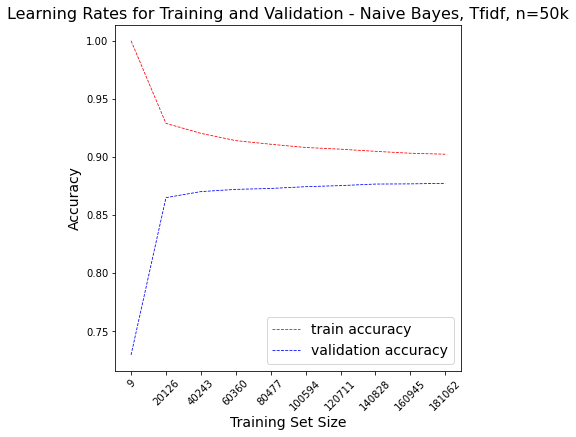

In [64]:
plot_learning_curves_feed_m(NB_clf, X_train_transformed, y_array, 
                           'Naive Bayes, Tfidf, n=50k')

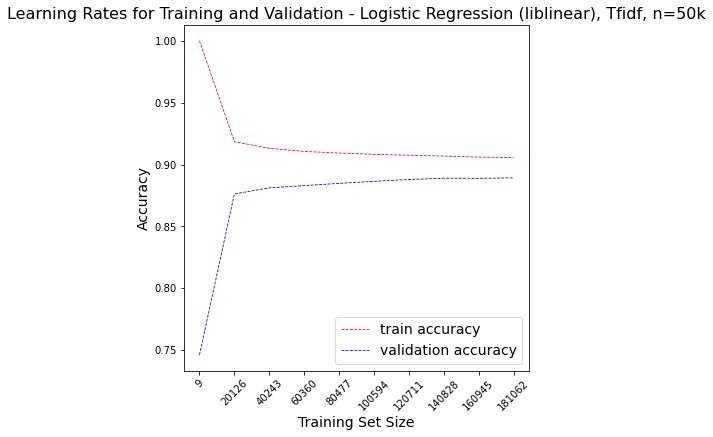

In [65]:
plot_learning_curves_feed_m(log_clf, X_train_transformed, y_array, 
                            'Logistic Regression (liblinear), Tfidf, n=50k')

In [66]:
def plot_learning_curves_feed_n(model, X, y, Xname):
    """Plot the learning curves for train and validation sets,
       by adding more features (n) and keeping the number of 
       rows (m) constant.
       Args:
           model: a classifier
           X: sparce matrix of features
           y: target vector
           Xname: vectorization method
       Evaluates accuracy (TODO: implement other metrics)
    """
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                          test_size=0.2, 
                                                          random_state=42)
    xs, train_acc, valid_acc = [], [], []

    # executive decision here, feeding 12 m data points
    for n in range(500, 50001, 4500):
        model.fit(X_train[:X.shape[0],:n], y_train)
        y_train_predict = model.predict(X_train[:X.shape[0],:n])
        y_valid_predict = model.predict(X_valid[:X.shape[0],:n])
        train_acc.append(accuracy_score(y_train, y_train_predict))
        valid_acc.append(accuracy_score(y_valid, y_valid_predict))
        xs.append(str(n-1))

    fig = plt.figure(figsize=(16, 6))
    ax = fig.add_axes([0.0, 
                       # dynamic x ticks would be len(range(x,y,z))
                       12, 
                       0.4, 0.8])
    plt.plot(xs, np.sqrt(train_acc), 'r--', linewidth=.8, 
             label="train accuracy")
    plt.plot(xs, np.sqrt(valid_acc), 'b--', linewidth=.8, 
             label="validation accuracy")
    plt.xticks(rotation=45)
    plt.title(''.join(["Learning Rates for Training and Validation - ", 
                       Xname]), 
              fontsize=16)
    plt.legend(loc="lower right", fontsize=14)
    plt.xlabel("Numer of Features", fontsize=14)
    plt.ylabel("Accuracy", fontsize=14)
    plt.show()

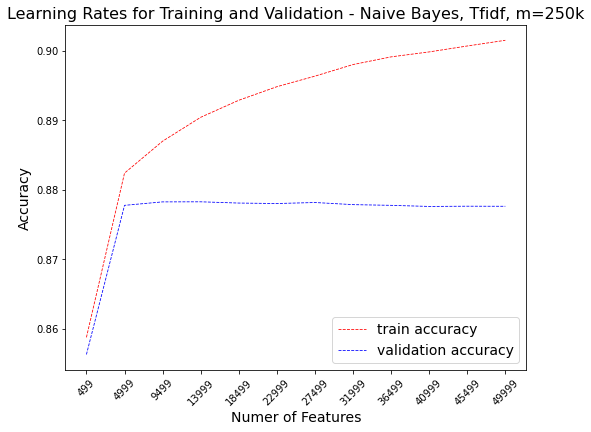

In [67]:
plot_learning_curves_feed_n(NB_clf, X_train_transformed, y_array, 
                            'Naive Bayes, Tfidf, m=250k')

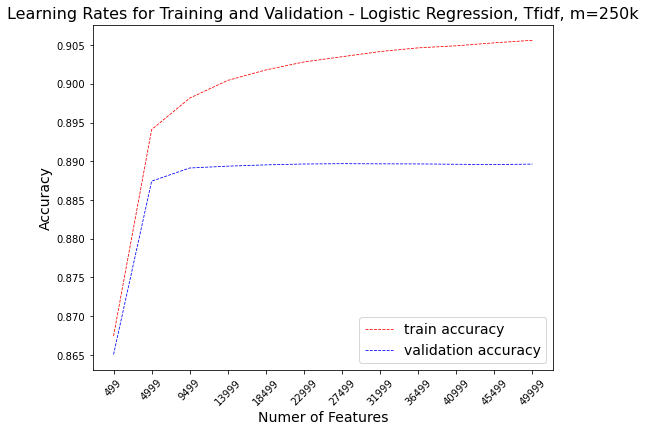

In [68]:
plot_learning_curves_feed_n(log_clf, X_train_transformed, y_array, 
                            'Logistic Regression, Tfidf, m=250k')

### Cross Validation

In [71]:
score = cross_val_score(NB_clf, X_train_transformed, y_array, cv=10, verbose=3, scoring='accuracy')
print('Mean accuracy: ' + str(score.mean()))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV]  ................................................................
[CV] .................................... , score=0.777, total=   0.1s
[CV]  ................................................................
[CV] .................................... , score=0.768, total=   0.1s
[CV]  ................................................................
[CV] .................................... , score=0.767, total=   0.1s
[CV]  ................................................................
[CV] .................................... , score=0.766, total=   0.1s
[CV]  ................................................................
[CV] .................................... , score=0.773, total=   0.1s
[CV]  ................................................................
[CV] .................................... , score=0.767, total=   0.1s
[CV]  ................................................................
[CV] .................................... , score=0.774, total=   0.1s
[CV]  

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.6s finished


In [72]:
score = cross_val_score(log_clf, X_train_transformed, y_array, cv=10, verbose=3, scoring='accuracy')
print('Mean accuracy: ' + str(score.mean()))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] .................................... , score=0.794, total=   2.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s


[CV] .................................... , score=0.790, total=   2.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.9s remaining:    0.0s


[CV] .................................... , score=0.790, total=   2.0s
[CV]  ................................................................
[CV] .................................... , score=0.791, total=   1.9s
[CV]  ................................................................
[CV] .................................... , score=0.797, total=   1.9s
[CV]  ................................................................
[CV] .................................... , score=0.791, total=   1.9s
[CV]  ................................................................
[CV] .................................... , score=0.794, total=   1.8s
[CV]  ................................................................
[CV] .................................... , score=0.794, total=   1.8s
[CV]  ................................................................
[CV] .................................... , score=0.791, total=   1.7s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   18.6s finished


Best accuracy so far, Tfidf is paying off perhaps.

---

---